# Convolutional Neural Networks

## MNIST Data Set - Basic Approach

### Get the MNIST Data

In [3]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist.train.images

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [5]:
mnist.train.num_examples

55000

In [6]:
mnist.test.num_examples

10000

In [7]:
mnist.validation.num_examples

5000

### Visualizing the Data

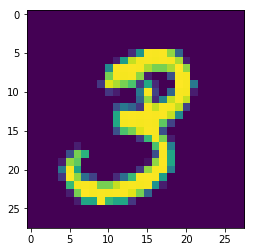

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
mnist.train.images[1].shape
plt.imshow(mnist.train.images[1].reshape(28,28))

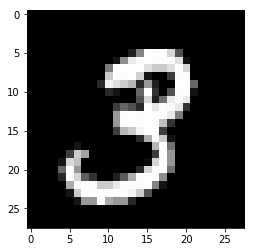

In [10]:
plt.imshow(mnist.train.images[1].reshape(28,28),cmap='gist_gray')

In [11]:
mnist.train.images[1].max()

1.0

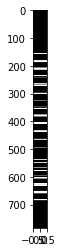

In [13]:
plt.imshow(mnist.train.images[1].reshape(784,1),
           cmap='gist_gray',aspect=0.02)

### Create the Model

In [14]:
x = tf.placeholder(tf.float32,shape=[None,784])
# 10 because 0-9 possible numbers
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))
# Create the Graph
y = tf.matmul(x,W) + b 
# Loss and Optimizer
y_true = tf.placeholder(tf.float32,[None,10])
# Cross Entropy
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        labels=y_true, logits=y))
optimizer = tf.train.GradientDescentOptimizer(
    learning_rate=0.5)
train = optimizer.minimize(cross_entropy)

### Create Session

In [16]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    # Train the model for 1000 steps on the training set
    # Using built in batch feeder from mnist for convenience
    for step in range(1000):
        batch_x , batch_y = mnist.train.next_batch(100)
        sess.run(train,feed_dict={x:batch_x,y_true:batch_y})
    # Test the Train Model
    matches = tf.equal(tf.argmax(y,1),tf.argmax(y_true,1))
    acc = tf.reduce_mean(tf.cast(matches,tf.float32))
    print(sess.run(acc,feed_dict={
        x:mnist.test.images,y_true:mnist.test.labels}))

0.9159


## MNIST with CNN

In [17]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Helper Functions

In [18]:
"""
Function to help intialize random weights for fully connected 
or convolutional layers, we leave the shape attribute as a 
parameter for this.
"""
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

Create a 2D convolution using builtin conv2d from TF. From those docs:

Computes a 2-D convolution given 4-D `input` and `filter` tensors.

Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
and a filter / kernel tensor of shape
`[filter_height, filter_width, in_channels, out_channels]`, this op
performs the following:

1. Flattens the filter to a 2-D matrix with shape
   `[filter_height * filter_width * in_channels, output_channels]`.
2. Extracts image patches from the input tensor to form a *virtual*
   tensor of shape `[batch, out_height, out_width,
   filter_height * filter_width * in_channels]`.
3. For each patch, right-multiplies the filter matrix and the image patch
   vector.

Create a max pooling layer, again using built in TF functions:

Performs the max pooling on the input.

    Args:
      value: A 4-D `Tensor` with shape `[batch, height, width, channels]` and
        type `tf.float32`.
      ksize: A list of ints that has length >= 4.  The size of the window for
        each dimension of the input tensor.
      strides: A list of ints that has length >= 4.  The stride of the sliding
        window for each dimension of the input tensor.
      padding: A string, either `'VALID'` or `'SAME'`. 
      
Using the conv2d function, we'll return an actual convolutional layer here that uses an ReLu activation.

In [19]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

### Placeholders

In [20]:
x = tf.placeholder(tf.float32,shape=[None,784])
y_true = tf.placeholder(tf.float32,shape=[None,10])

### Layers

In [21]:
x_image = tf.reshape(x,[-1,28,28,1])
"""
Using a 6by6 filter here, used 5by5 in video, 
you can play around with the filter size. You 
can change the 32 output, that essentially 
represents the amount of filters used.You need 
to pass in 32 to the next input though, the 1 
comes from the original input of a single image.
"""
convo_1 = convolutional_layer(x_image,shape=[6,6,1,32])
convo_1_pooling = max_pool_2by2(convo_1)
"""
Using a 6by6 filter here, used 5by5 in video, 
you can play around with the filter size. You can 
actually change the 64 output if you want, you can 
think of that as a representation of the amount of 
6by6 filters used.
"""
convo_2 = convolutional_layer(convo_1_pooling,shape=[6,6,32,64])
convo_2_pooling = max_pool_2by2(convo_2)
"""
Why 7 by 7 image? Because we did 2 pooling layers, 
so (28/2)/2 = 7. 64 then just comes from the output 
of the previous Convolution.
"""
convo_2_flat = tf.reshape(convo_2_pooling,[-1,7*7*64])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))
# NOTE THE PLACEHOLDER HERE!
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)
y_pred = normal_full_layer(full_one_dropout,10)

### Loss Function, Optimizer, Init

In [23]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        labels=y_true,logits=y_pred))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer.minimize(cross_entropy)
init = tf.global_variables_initializer()

### Session

In [24]:
#  You might want to use graphics acceleration.
steps = 5000
with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        batch_x , batch_y = mnist.train.next_batch(50)
        sess.run(train,feed_dict={x:batch_x,y_true:batch_y,hold_prob:0.5})
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%500 == 0:
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            print(sess.run(acc,feed_dict={
                x:mnist.test.images,y_true:mnist.test.labels,hold_prob:1.0}))
            print('\n')

Currently on step 0
Accuracy is:
0.0851


Currently on step 500
Accuracy is:
0.9476


Currently on step 1000
Accuracy is:
0.9651


Currently on step 1500
Accuracy is:
0.9742


Currently on step 2000
Accuracy is:
0.9773


Currently on step 2500
Accuracy is:
0.9814


Currently on step 3000
Accuracy is:
0.9832


Currently on step 3500
Accuracy is:
0.9827


Currently on step 4000
Accuracy is:
0.9853


Currently on step 4500
Accuracy is:
0.9857




## CNN Exercise

We'll be using the CIFAR-10 dataset, which is very famous dataset for image recognition! 

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

### Step 0: Get the Data

The archive contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch. Each of these files is a Python "pickled" object produced with cPickle. 

**Load the Data. Use the Code Below to load the data: **

In [1]:
CIFAR_DIR = 'cifar-10-batches-py/'
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict
dirs = ['batches.meta','data_batch_1',
        'data_batch_2','data_batch_3',
        'data_batch_4','data_batch_5',
        'test_batch']
all_data = [0,1,2,3,4,5,6]
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)
    batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

Loaded in this way, each of the batch files contains a dictionary with the following elements:
* data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
* labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:

* label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

### Display a single image using matplotlib.

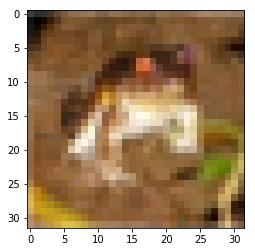

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

X = data_batch1[b"data"]
"""
Images are flattened, so we transpose here to view!
"""
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
plt.imshow(X[0])

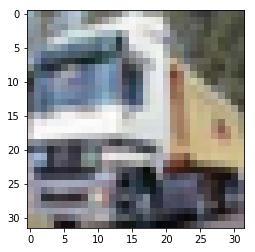

In [3]:
plt.imshow(X[1])

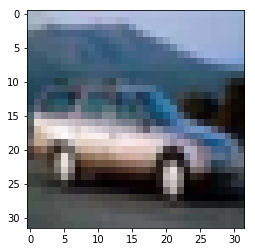

In [4]:
plt.imshow(X[4])

### Helper Functions for Dealing With Data.

In [5]:
def one_hot_encode(vec, vals=10):
    #For use to one-hot encode the 10- possible labels
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

class CifarHelper():
    def __init__(self):
        self.i = 0
        self.all_train_batches = [
            data_batch1,data_batch2,
            data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]
        self.training_images = None
        self.training_labels = None
        self.test_images = None
        self.test_labels = None
    def set_up_images(self):
        print("Setting Up Training Images and Labels")
        self.training_images = np.vstack(
            [d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        self.training_images = self.training_images.reshape(
            train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(
            np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        print("Setting Up Test Images and Labels")
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        self.test_images = self.test_images.reshape(
            test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack(
            [d[b"labels"] for d in self.test_batch]), 10)
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(batch_size,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [6]:
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()

# During your session to grab the next batch use this line
# (Just like we did for mnist.train.next_batch)
# batch = ch.next_batch(100)

Setting Up Training Images and Labels
Setting Up Test Images and Labels


### Creating the Model

**Import tensorflow **

**Create 2 placeholders, x and y_true. Their shapes should be: **

**Create one more placeholder called hold_prob. No need for shape here. This placeholder will just hold a single probability for the dropout. **

#### Helper Functions

**Grab the helper functions from MNIST with CNN (or recreate them here yourself for a hard challenge!). You'll need: **

* init_weights
* init_bias
* conv2d
* max_pool_2by2
* convolutional_layer
* normal_full_layer

In [9]:
x = tf.placeholder(tf.float32,shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32,shape=[None,10])
hold_prob = tf.placeholder(tf.float32)
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

### Create the Layers

**Create a convolutional layer and a pooling layer as we did for MNIST. **
**Its up to you what the 2d size of the convolution should be, but the last two digits need to be 3 and 32 because of the 3 color channels and 32 pixels. So for example you could use:**

        convo_1 = convolutional_layer(x,shape=[4,4,3,32])

**Create the next convolutional and pooling layers.  The last two dimensions of the convo_2 layer should be 32,64 **

**Now create a flattened layer by reshaping the pooling layer into [-1,8 \* 8 \* 64] or [-1,4096] **

**Create a new full layer using the normal_full_layer function and passing in your flattend convolutional 2 layer with size=1024. (You could also choose to reduce this to something like 512)**

**Now create the dropout layer with tf.nn.dropout, remember to pass in your hold_prob placeholder. **

**Finally set the output to y_pred by passing in the dropout layer into the normal_full_layer function. The size should be 10 because of the 10 possible labels**

In [10]:
convo_1 = convolutional_layer(x,shape=[4,4,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

convo_2 = convolutional_layer(convo_1_pooling,shape=[4,4,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])

full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

y_pred = normal_full_layer(full_one_dropout,10)

### Loss Function, Optimizer, Init

**Create a cross_entropy loss function **

**Create the optimizer using an Adam Optimizer. **

**Create a variable to intialize all the global tf variables. **

In [11]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

init = tf.global_variables_initializer()

### Graph Session

**Perform the training and test print outs in a Tf session and run your model! **

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(5000):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={
            x: batch[0], y_true: batch[1], hold_prob: 0.5})
        # PRINT OUT A MESSAGE EVERY 1000 STEPS
        if i%500 == 0:
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            print(sess.run(acc,feed_dict={
                x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0}))
            print('\n')

Currently on step 0
Accuracy is:
0.1


Currently on step 500
Accuracy is:
0.5624


Currently on step 1000
Accuracy is:
0.6256


Currently on step 1500
Accuracy is:
0.6316


Currently on step 2000
Accuracy is:
0.6698


Currently on step 2500
Accuracy is:
0.6721


Currently on step 3000
Accuracy is:
0.673


Currently on step 3500
Accuracy is:
0.6903


Currently on step 4000
Accuracy is:
0.6932


Currently on step 4500
Accuracy is:
0.6909


